# 版本说明v6 #
1. 使用LinearRegressor
2. 使用pipeline
3. 添加自定义的Transformer，可以选择指定的成分
4. 针对各个参数进行了调优
5. 封装了工具方法
6. 是mse作为scoring
7. 对原始数据重新排序

# 拆分训练集和验证集 #

In [29]:
from hw1_utils_v5 import *
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

X_train_full,y_train_full,X_test,test_options = load_data() # 加载训练和测试数据

n_features = X_train_full.shape[1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
new_index = np.arange(X_train_full.shape[0])
np.random.RandomState(0).shuffle(new_index) # 生成新的索引

In [31]:
# 重新排序一下
X_train_full = X_train_full.reindex(new_index)
y_train_full = pd.DataFrame(y_train_full).reindex(new_index).to_numpy().ravel()

In [32]:
X_train_full.index = range(X_train_full.shape[0]) # 重新生成一下index

# 使用LinearRegression模型 ##

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

def rmse_cross_val_score(model,X,y):
    return cross_val_score(model,X,y,scoring='neg_root_mean_squared_error').mean() * -1
    
rmse_cross_val_score(LinearRegression(),X_train_full,y_train_full)

5.915237888430732

# 比较真实值和预测值的分布 

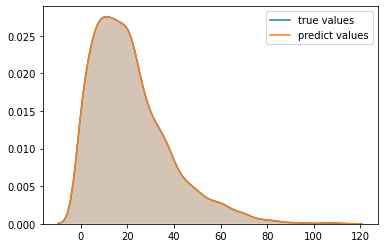

In [41]:
import seaborn as sns
sns.kdeplot(data=y_train_full,shade=True,label='true values')
y_hat = LinearRegression().fit(X_train_full,y_train_full).predict(X_train_full)
sns.kdeplot(data=y_train_full,shade=True,label='predict values')

## 有用的方法 ##
**删除无关测项**   
1. 将所有feature放进去，计算cv_score，记录为best score
2. 然后分别减掉一个feature，选出最高的cv_score，如果，如果比best_score，那么去掉这个feature
3. 然后重复上面的操作，直到最高的score不再比best_score高为止。  

**嵌入法**：threshold = 0.0111   

## 被排除的方法如下：##
**方差过滤**：基本没有影响   
**F值过滤**：最大的p也只有e-26   
**互信息法**：没有可以删除的feature   
**分箱法**：没有用   

In [7]:
from sklearn.pipeline import Pipeline

options = SelectTestOptionTransformer()
pipeline = Pipeline(steps=[('options',options),
                           ('model',LinearRegression())])
options.exclude = []

train_best_scores = []
valid_best_scores = []
exclude_params = [] # 已经被排除的测项
best_score = -5.915237888430732
flag = True
while flag:
    # 将已经排除的加上一个新的测项，作为本次遍历的已排除测项
    param_range = [exclude_params + [test_options[i]] for i in range(18)]
    
    train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                                 'options__exclude',param_range,
                                                 scoring='neg_root_mean_squared_error')
    
    valid_score = valid_scores.mean(axis=1)              # 取验证集每个feature的平均分
    valid_max = valid_score.max()                        # 取出最高分
    valid_argmax = valid_score.argmax()                  # 最高分对应的feature值
    train_max = train_scores.mean(axis=1)[valid_argmax]  # 该feature在训练集的分数作为训练集最高分
    
    if valid_max > best_score:
        train_best_scores.append(train_max)
        valid_best_scores.append(valid_max)
        best_score = valid_max
        if len(valid_score) > 1:
            test_option_killed = test_options[valid_argmax]
            exclude_params.append(test_option_killed)
        print('剔除{}后，训练集得分为{:.4f}，验证集得分为{:.4f}'.format(
            test_option_killed,train_max,valid_max))
            
    else:
        print('剔除完成。')
        flag = False

剔除NMHC后，训练集得分为-5.6605，验证集得分为-5.9024
剔除THC后，训练集得分为-5.6631，验证集得分为-5.8908
剔除CH4后，训练集得分为-5.6737，验证集得分为-5.8832
剔除WIND_SPEED后，训练集得分为-5.6777，验证集得分为-5.8777
剔除SO2后，训练集得分为-5.6963，验证集得分为-5.8719
剔除WD_HR后，训练集得分为-5.7049，验证集得分为-5.8678
剔除RH后，训练集得分为-5.7208，验证集得分为-5.8643
剔除AMB_TEMP后，训练集得分为-5.7276，验证集得分为-5.8587
剔除NO后，训练集得分为-5.7343，验证集得分为-5.8561
剔除WS_HR后，训练集得分为-5.7409，验证集得分为-5.8540
剔除NOx后，训练集得分为-5.7503，验证集得分为-5.8532
剔除RAINFALL后，训练集得分为-5.7570，验证集得分为-5.8528
剔除完成。


## 噪音过滤后的学习曲线 ##

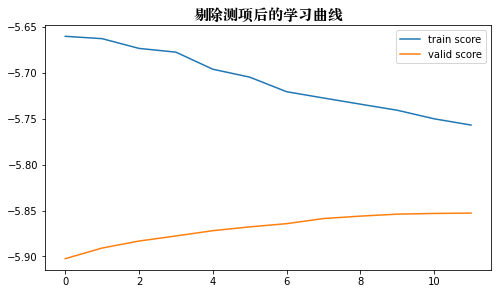

In [26]:
from matplotlib.font_manager import FontProperties

def plot_best_scores():
    myfont = FontProperties(fname='/Library/Fonts/Songti.ttc',size=15)
    plt.figure(figsize=(8,4.5))
    plt.title('剔除测项后的学习曲线',fontproperties=myfont)
    x = len(train_best_scores)
    plt.plot(range(x),train_best_scores,label='train score')
    plt.plot(range(x),valid_best_scores,label='valid score')
    plt.legend()
    plt.show()
    
plot_best_scores()

In [9]:
best_score * (-1)

5.8528064193839295

In [10]:
print(exclude_params)

['NMHC', 'THC', 'CH4', 'WIND_SPEED', 'SO2', 'WD_HR', 'RH', 'AMB_TEMP', 'NO', 'WS_HR', 'NOx', 'RAINFALL']


# 标准化 

In [12]:
from sklearn.preprocessing import StandardScaler

exclude_params = ['NMHC', 'THC', 'CH4', 'WIND_SPEED', 'SO2', 'WD_HR', 'RH', 
                  'AMB_TEMP', 'NO', 'WS_HR', 'NOx', 'RAINFALL']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('model',LinearRegression())])

cross_val_score(pipeline,X_train_full,y_train_full,n_jobs=-1,
                scoring='neg_root_mean_squared_error').mean() * (-1)

5.8528064193839295

# 方差过滤 #
**总结**：方差过滤没有影响

In [13]:
from sklearn.feature_selection import VarianceThreshold

exclude_params = ['NMHC', 'THC', 'CH4', 'WIND_SPEED', 'SO2', 'WD_HR', 'RH', 
                  'AMB_TEMP', 'NO', 'WS_HR', 'NOx', 'RAINFALL']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('vt',VarianceThreshold()),
                           ('model',LinearRegression())])

In [14]:
treshold_range = [0.01 * i for i in range(20)]

train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                             'vt__threshold',treshold_range,
                                             scoring='neg_root_mean_squared_error')

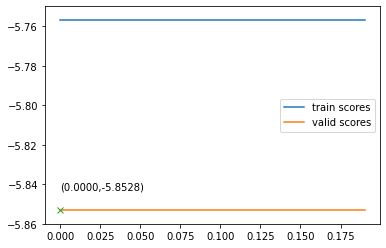

(0.0, -5.85280641938393)

In [17]:
plot_validation_curve(train_scores,valid_scores,treshold_range,ylim=(-5.86,-5.75))

# F值过滤 #
**总结**：p值基本都等于0，虽然学习曲线44的时候值最大，但是把cv调到10之后，33的是最大，存在很大的随机性，而且数字差别也不大，暂时不用F值过滤

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

exclude_params = ['NMHC', 'THC', 'CH4', 'WIND_SPEED', 'SO2', 'WD_HR', 'RH', 
                  'AMB_TEMP', 'NO', 'WS_HR', 'NOx', 'RAINFALL']

f_range = range(1,55)

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('f',SelectKBest(f_regression)),
                           ('model',LinearRegression())])
train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                             'f__k',f_range,n_jobs=-1,
                                             error_score=0,verbose=1,cv=5,
                                             scoring='neg_root_mean_squared_error')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   18.6s finished


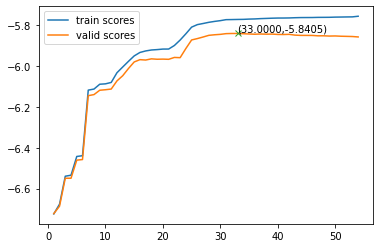

(33, -5.8404649538892714)

In [29]:
plot_validation_curve(train_scores,valid_scores,f_range)

# 互信息法

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression


exclude_params =  ['NMHC', 'THC', 'CH4', 'WIND_SPEED', 'SO2', 'WD_HR', 'RH', 
                  'AMB_TEMP', 'NO', 'WS_HR', 'NOx', 'RAINFALL']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('f',SelectKBest(f_regression,33)),
                           ('mir',SelectKBest(mutual_info_regression)),
                           ('model',LinearRegression())])

train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                             'mir__k',range(29,34),n_jobs=-1,
                                             error_score=0,verbose=1,cv=5,
                                             scoring='neg_root_mean_squared_error')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   29.7s finished


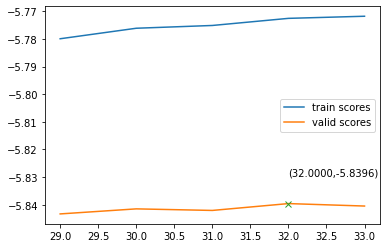

(32, -5.839575766299082)

In [36]:
plot_validation_curve(train_scores,valid_scores,range(29,34)) # 符合预期，没有元素可以删除

# 嵌入法

In [40]:
from sklearn.feature_selection import SelectFromModel

exclude_params =  ['NMHC', 'THC', 'CH4', 'WIND_SPEED', 'SO2', 'WD_HR', 'RH', 
                  'AMB_TEMP', 'NO', 'WS_HR', 'NOx', 'RAINFALL']
pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('f',SelectKBest(f_regression,33)),
                           ('mir',SelectKBest(mutual_info_regression,32)),
                           ('sfm',SelectFromModel(LinearRegression())),
                           ('model',LinearRegression())])

train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                             'sfm__threshold',np.linspace(0,0.02,10),
                                             scoring='neg_root_mean_squared_error')

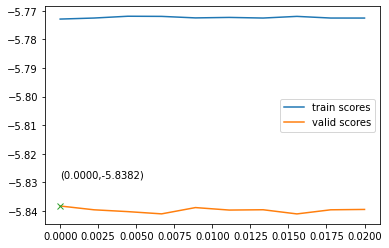

(0.0, -5.838246851696371)

In [41]:
plot_validation_curve(train_scores,valid_scores,np.linspace(0,0.02,10))

# 输出数据 #

In [42]:
exclude_params = ['NMHC', 'THC', 'CH4', 'WIND_SPEED', 'SO2', 'WD_HR', 'RH', 
                  'AMB_TEMP', 'NO', 'WS_HR', 'NOx', 'RAINFALL']

pipeline = Pipeline(steps=[('options',SelectTestOptionTransformer(exclude_params)),
                           ('std',StandardScaler()),
                           ('f',SelectKBest(f_regression,33)),
                           ('mir',SelectKBest(mutual_info_regression,32)),
                           ('sfm',SelectFromModel(LinearRegression(),0)),
                           ('model',LinearRegression())])

pipeline.fit(X_train_full,y_train_full)

preds_test = pipeline.predict(X_test)
ids = ['id_' + str(i) for i in range(len(X_test))]
output = pd.DataFrame({'id':ids,
                           'value':preds_test})
output.to_csv('output/pm25_submission.csv',index=False)

In [43]:
preds_test.max()

124.22486191834608

In [44]:
preds_test.min()

0.8019995477010688

In [46]:
y_train_full.max()

112.0

In [47]:
y_train_full.min()

-1.0